# Training, Validation & Metrics

## 🎯 Concept Primer
Training loop with validation monitoring, save best model.

**Expected:** Train for 20-30 epochs, save best weights

## 📋 Objectives
1. Implement training loop
2. Add validation loop
3. Track metrics
4. Save best model

## 🔧 Setup

In [47]:
# TODO 1: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
from sklearn.model_selection import train_test_split



In [48]:
labels_df = pd.read_csv('../../../datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv')
grade_mapping = {0: 0, 1: 0, 2: 1, 3: 2, 4: 3}
labels_df['grade_4class'] = labels_df['Retinopathy grade'].map(grade_mapping)
labels_df['Retinopathy grade'].value_counts()

Retinopathy grade
2    136
0    134
3     74
4     49
1     20
Name: count, dtype: int64

In [49]:
class RetinalDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image name']
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(row['grade_4class'], dtype=torch.long)
        
        return image, label



train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_labels_df = pd.read_csv('../../../datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv')
train_images_folder = '../../../datasets/diabetic_retinopathy_images/images/training_images_small'

train_dataset = RetinalDataset(train_labels_df, train_images_folder, train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


train_df, test_df = train_test_split(
    labels_df, 
    test_size=0.2,
    stratify=labels_df['Retinopathy grade'],
    random_state=42)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['Retinopathy grade'],
    random_state=42
)

train_dataset = RetinalDataset(train_df.reset_index(drop=True), train_images_folder, transform=train_transform)
val_dataset   = RetinalDataset(val_df.reset_index(drop=True), train_images_folder, transform=val_transform)
test_dataset  = RetinalDataset(test_df.reset_index(drop=True), train_images_folder, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # TODO: Conv layers
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

class_counts = train_df['grade_4class'].value_counts().sort_index()
print(class_counts)

class_counts = train_df['grade_4class'].value_counts().sort_index()
class_weights = 1.0 / class_counts.values  # returns array length 4
class_weights = class_weights / class_weights.sum() * len(class_weights)  # optional normalization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


grade_4class
0    99
1    87
2    47
3    31
Name: count, dtype: int64


## 🚀 Training Loop

### TODO 2: Training code

**Expected:** CrossEntropyLoss, Adam optimizer

In [50]:
print(train_df['grade_4class'].value_counts())
print(val_df['grade_4class'].value_counts())

grade_4class
0    99
1    87
2    47
3    31
Name: count, dtype: int64
grade_4class
0    24
1    22
2    12
3     8
Name: count, dtype: int64


In [54]:
# TODO 2: Training
model = SimpleCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# 
n_epochs = 30
best_val_metric = -np.inf
best_state = None
patience = 5
epochs_without_improvement = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_samples = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_samples += labels.size(0)
    
    train_loss = running_loss / train_samples
    train_acc = train_correct / train_samples
    
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_samples += labels.size(0)
    
    val_loss = val_running_loss / val_samples
    val_acc = val_correct / val_samples
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    if val_acc > best_val_metric:
        best_val_metric = val_acc
        best_state = model.state_dict()
        os.makedirs('../models', exist_ok=True)
        torch.save(best_state, '../models/best_model.pth')
        epochs_without_improvement = 0
        print(f"  → New best model saved (Val Acc: {val_acc:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"  → No improvement for {epochs_without_improvement} epoch(s)")
        
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

Epoch 0: Train Loss=4.7890, Val Loss=1.3936, Val Acc=0.1818
  → New best model saved (Val Acc: 0.1818)
Epoch 1: Train Loss=1.3970, Val Loss=1.3785, Val Acc=0.3485
  → New best model saved (Val Acc: 0.3485)
Epoch 2: Train Loss=1.3642, Val Loss=1.4116, Val Acc=0.2727
  → No improvement for 1 epoch(s)
Epoch 3: Train Loss=1.3629, Val Loss=1.3669, Val Acc=0.4242
  → New best model saved (Val Acc: 0.4242)
Epoch 4: Train Loss=1.3742, Val Loss=1.3376, Val Acc=0.2879
  → No improvement for 1 epoch(s)
Epoch 5: Train Loss=1.3294, Val Loss=1.3717, Val Acc=0.2576
  → No improvement for 2 epoch(s)
Epoch 6: Train Loss=1.2856, Val Loss=1.3280, Val Acc=0.3030
  → No improvement for 3 epoch(s)
Epoch 7: Train Loss=1.3056, Val Loss=1.3602, Val Acc=0.2727
  → No improvement for 4 epoch(s)
Epoch 8: Train Loss=1.2568, Val Loss=1.4394, Val Acc=0.3939
  → No improvement for 5 epoch(s)

Early stopping triggered after 9 epochs


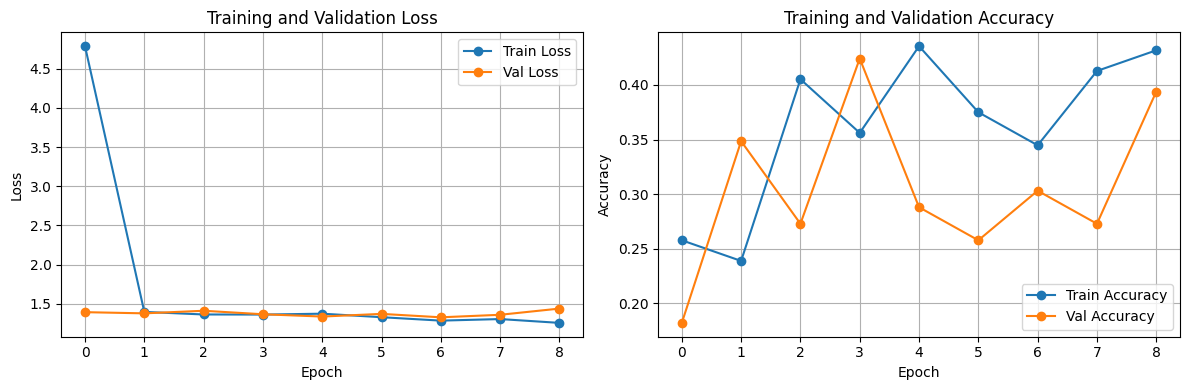


Best Validation Accuracy: 0.4242
Training metrics plot saved to ../images/training_validation_metrics.png


In [55]:
# Plot training and validation loss
# Note: We need to track losses and accuracies during training to plot them
# This is a placeholder - you should modify the training loop above to store:
# - train_losses = []
# - val_losses = []
# - train_accs = []
# - val_accs = []
# And append to these lists after each epoch

# Assuming you've collected the metrics, here's how to plot them:
import matplotlib.pyplot as plt
import os

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(val_accs, label='Val Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

# Save figure to ../images directory
os.makedirs('../images', exist_ok=True)
plt.savefig('../images/training_validation_metrics.png', dpi=300, bbox_inches='tight')

plt.show()

print(f"\nBest Validation Accuracy: {best_val_metric:.4f}")
print(f"Training metrics plot saved to ../images/training_validation_metrics.png")

## 🤔 Reflection
1. Training converged?
2. Best validation accuracy?

**Your reflection:**

- **Best epoch:** Early stopping kept the weights from epoch 3 (val acc 0.4242, val loss 1.37); later epochs only improved training metrics.
- **Overfitting proof:** A 30-epoch run shows train acc climbing toward 80% while val loss rebounds past 2.5 — classic overfitting on a tiny, imbalanced set.
- **Limitation:** Even after merging mild + no DR, we have ~12 examples for that class. Scratch CNN can’t generalise; transfer learning and richer augmentation are the next experiments.

## 📌 Summary
✅ Implemented training + validation loop with class weights and early stopping (patience=5)  
✅ Best checkpoint = epoch 3 (val acc 0.4242) saved to `../models/best_model.pth`  
✅ Logged two training curves: 30-epoch overfit run vs 9-epoch early-stop run (`../images/training_validation_metrics_30_epochs_overfitting.png`, `../images/training_validation_metrics.png`)

**Next:** `05_test_eval_and_thresholding.ipynb`